# Insurance Premium Prediction - Kaggle Playground Series S4E12
#### Author: Ahmad AlModhayan
#### Date: 2024-12-10

## Overview
This notebook implements a machine learning solution for predicting insurance premiums using ensemble methods.

In [7]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_log_error
import xgboost as xgb
import lightgbm as lgb
import warnings
import logging

warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

#### 1. Data Loading and Initial Analysis


In [6]:
print("Loading data...")
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

print(f"Training Data Shape: {train_df.shape}")
print(f"\nTest Data Shape: {test_df.shape}")
print("\nTraining Data Info:")
train_df.info()

Loading data...
Training Data Shape: (1200000, 21)

Test Data Shape: (800000, 20)

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1200000 non-null  int64  
 1   Age                   1181295 non-null  float64
 2   Gender                1200000 non-null  object 
 3   Annual Income         1155051 non-null  float64
 4   Marital Status        1181471 non-null  object 
 5   Number of Dependents  1090328 non-null  float64
 6   Education Level       1200000 non-null  object 
 7   Occupation            841925 non-null   object 
 8   Health Score          1125924 non-null  float64
 9   Location              1200000 non-null  object 
 10  Policy Type           1200000 non-null  object 
 11  Previous Claims       835971 non-null   float64
 12  Vehicle Age           1199994 non-nul

#### 2. Exploratory Data Analysis


##### Numerical Data Plotting

In [ ]:
def plot_numeric_distributions(df, columns):
    plt.figure(figsize=(15, 5*((len(columns)+2)//3)))
    for i, col in enumerate(columns, 1):
        plt.subplot((len(columns)+2)//3, 3, i)
        sns.histplot(df[col].dropna(), kde=True)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
    plt.tight_layout()
    plt.show()

##### Categorical Data Plotting

In [ ]:
def plot_categorical_distributions(df, columns):
    plt.figure(figsize=(15, 5*((len(columns)+2)//3)))
    for i, col in enumerate(columns, 1):
        plt.subplot((len(columns)+2)//3, 3, i)
        df[col].value_counts().plot(kind='bar')
        plt.title(f'Distribution of {col}')
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

##### Separate numeric and categorical columns

In [ ]:
numeric_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = train_df.select_dtypes(include=['object']).columns

print("\nPlotting numeric distributions...")
plot_numeric_distributions(train_df, numeric_cols)

print("\nPlotting categorical distributions...")
plot_categorical_distributions(train_df, categorical_cols)

#### 3. Feature Engineering

In [8]:
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")


class FeatureEngineer:
    def __init__(self):
        self.label_encoders = {}
        self.scaler = StandardScaler()

    @staticmethod
    def standardize_column_names(df):
        """Standardizes column names by replacing spaces with underscores and converting to lowercase."""
        df.columns = df.columns.str.replace(' ', '_').str.replace('/', '_').str.lower()
        return df

    def transform_dates(self, df):
        """Extracts date-related features and drops the original date column."""
        df = df.copy()
        if 'policy_start_date' in df.columns:
            df['policy_start_date'] = pd.to_datetime(df['policy_start_date'], errors='coerce')
            df['policy_start_year'] = df['policy_start_date'].dt.year
            df['policy_start_month'] = df['policy_start_date'].dt.month
            df['policy_start_quarter'] = df['policy_start_date'].dt.quarter
            df.drop('policy_start_date', axis=1, inplace=True)
        else:
            logging.warning("Policy Start Date column not found.")
        return df

    def create_interactions(self, df):
        """Generates interaction features."""
        df = df.copy()

        # Basic ratio features
        if 'annual_income' in df.columns and 'age' in df.columns:
            df['age_income_ratio'] = df['age'] / (df['annual_income'] + 1)

        if 'annual_income' in df.columns and 'number_of_dependents' in df.columns:
            df['income_per_dependent'] = df['annual_income'] / (df['number_of_dependents'] + 1)

        if 'health_score' in df.columns and 'age' in df.columns:
            df['health_age_ratio'] = df['health_score'] / df['age']

        # Risk-based features
        if all(col in df.columns for col in ['health_score', 'credit_score', 'age']):
            df['risk_score'] = df['health_score'] * df['credit_score'] / (df['age'] + 1)

        if all(col in df.columns for col in ['previous_claims', 'insurance_duration']):
            df['claims_duration_ratio'] = df['previous_claims'] / (df['insurance_duration'] + 1)

        # Interaction with categorical features
        if 'policy_type' in df.columns and 'annual_income' in df.columns:
            df['income_by_policy_type'] = df['annual_income'] / df.groupby('policy_type')['annual_income'].transform('mean')

        if 'location' in df.columns and 'health_score' in df.columns:
            df['health_score_by_location'] = df['health_score'] / df.groupby('location')['health_score'].transform('mean')

        return df

    def encode_categoricals(self, df, is_training=True):
        """Encodes categorical features with Label Encoding."""
        df = df.copy()
        for col in df.select_dtypes(include=['object']).columns:
            if is_training:
                self.label_encoders[col] = LabelEncoder()
                df[col] = self.label_encoders[col].fit_transform(df[col].fillna('Unknown'))
            else:
                if col in self.label_encoders:
                    # Handle unknown categories in the test set
                    df[col] = df[col].fillna('Unknown')
                    df[col] = df[col].map(
                        lambda x: self.label_encoders[col].transform([x])[0] if x in self.label_encoders[col].classes_ else -1
                    )
                else:
                    logging.warning(f"Encoder for column {col} not found. Skipping encoding.")
        return df

    def scale_features(self, df, is_training=True):
        """Scales numerical features using StandardScaler."""
        df = df.copy()
        numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
        numeric_cols = [col for col in numeric_cols if col not in ['id', 'premium_amount']]

        if is_training:
            df[numeric_cols] = self.scaler.fit_transform(df[numeric_cols].fillna(0))
        else:
            df[numeric_cols] = self.scaler.transform(df[numeric_cols].fillna(0))
        return df

    def transform(self, df, is_training=True):
        """Applies all transformations in sequence."""
        df = self.standardize_column_names(df)
        df = self.transform_dates(df)
        df = self.create_interactions(df)
        df = self.encode_categoricals(df, is_training)
        df = self.scale_features(df, is_training)
        return df

#### 4. Model Training and Evaluation

In [9]:
class ModelTrainer:
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.models = {}

    def train_xgboost(self, X_train, y_train, X_val=None, y_val=None):
        params = {
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'max_depth': 8,
            'learning_rate': 0.05,
            'n_estimators': 1000,
            'min_child_weight': 3,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'random_state': self.random_state
        }

        if X_val is not None and y_val is not None:
            dtrain = xgb.DMatrix(X_train, label=y_train)
            dval = xgb.DMatrix(X_val, label=y_val)
            evals = [(dtrain, 'train'), (dval, 'eval')]

            model = xgb.train(
                params,
                dtrain,
                num_boost_round=1000,
                evals=evals,
                early_stopping_rounds=50,
                verbose_eval=10
            )
        else:
            model = xgb.XGBRegressor(**params)
            model.fit(X_train, y_train)

        return model

    def train_lightgbm(self, X_train, y_train, X_val=None, y_val=None):
        params = {
            'objective': 'regression',
            'metric': 'rmse',
            'num_leaves': 31,
            'learning_rate': 0.05,
            'n_estimators': 1000,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'random_state': self.random_state
        }

        X_train.columns = X_train.columns.str.replace(' ', '_')
        X_val.columns = X_val.columns.str.replace(' ', '_')

        model = lgb.LGBMRegressor(**params)

        if X_val is not None and y_val is not None:
            model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                eval_metric="rmse",
                callbacks=[lgb.early_stopping(stopping_rounds=50)]
            )
        else:
            model.fit(X_train, y_train)

        return model

    def train_with_kfold(self, X, y, n_splits=5):
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=self.random_state)
        oof_predictions = np.zeros(len(X))

        for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
            print(f"\nTraining Fold {fold}")
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            xgb_model = self.train_xgboost(X_train, y_train, X_val, y_val)
            lgb_model = self.train_lightgbm(X_train, y_train, X_val, y_val)

            xgb_pred = xgb_model.predict(xgb.DMatrix(X_val))
            lgb_pred = lgb_model.predict(X_val)

            fold_pred = 0.5 * (xgb_pred + lgb_pred)
            oof_predictions[val_idx] = fold_pred

            fold_score = np.sqrt(mean_squared_log_error(y_val, fold_pred))
            print(f"Fold {fold} RMSLE: {fold_score:.5f}")

            self.models[f'xgb_fold_{fold}'] = xgb_model
            self.models[f'lgb_fold_{fold}'] = lgb_model

        overall_score = np.sqrt(mean_squared_log_error(y, oof_predictions))
        print(f"\nOverall RMSLE: {overall_score:.5f}")

        return oof_predictions

    def predict(self, X):
        predictions = []
        X.columns = X.columns.str.replace(' ', '_')

        for name, model in self.models.items():
            if isinstance(model, xgb.Booster):
                pred = model.predict(xgb.DMatrix(X))
            else:
                pred = model.predict(X)
            predictions.append(pred)

        final_pred = np.mean(predictions, axis=0)
        return final_pred


#### 5. Main Training Pipeline

In [10]:
print("\nStarting main training pipeline...")

# Initialize feature engineer
fe = FeatureEngineer()

# Prepare features
print("Preparing features...")
X = train_df.drop(['Premium Amount', 'id'], axis=1)
y = np.log1p(train_df['Premium Amount'])  # Log transform target
X = fe.transform(X, is_training=True)
print("Features prepared!")


Starting main training pipeline...
Preparing features...
Features prepared!


In [11]:
# Train models
print("\nTraining models...")
trainer = ModelTrainer(random_state=RANDOM_STATE)
oof_predictions = trainer.train_with_kfold(X, y)
print("\nTraining completed!")

# Prepare test data
print("\nPreparing test data...")
test_features = test_df.drop(['id'], axis=1)
test_features = fe.transform(test_features, is_training=False)
print("\nPreparing test data completed!")

# Make predictions
print("Making final predictions...")
test_predictions = trainer.predict(test_features)
test_predictions = np.expm1(test_predictions)  # Inverse log transform
print("\nPredictions completed!")



Training models...

Training Fold 1
[0]	train-rmse:1.09291	eval-rmse:1.09373
[10]	train-rmse:1.06673	eval-rmse:1.06868
[20]	train-rmse:1.05352	eval-rmse:1.05646
[30]	train-rmse:1.04763	eval-rmse:1.05158
[40]	train-rmse:1.04428	eval-rmse:1.04913
[50]	train-rmse:1.04245	eval-rmse:1.04821
[60]	train-rmse:1.04096	eval-rmse:1.04759
[70]	train-rmse:1.03987	eval-rmse:1.04734
[80]	train-rmse:1.03894	eval-rmse:1.04724
[90]	train-rmse:1.03803	eval-rmse:1.04717
[100]	train-rmse:1.03719	eval-rmse:1.04713
[110]	train-rmse:1.03634	eval-rmse:1.04709
[120]	train-rmse:1.03550	eval-rmse:1.04705
[130]	train-rmse:1.03464	eval-rmse:1.04705
[140]	train-rmse:1.03386	eval-rmse:1.04703
[150]	train-rmse:1.03305	eval-rmse:1.04705
[160]	train-rmse:1.03223	eval-rmse:1.04707
[170]	train-rmse:1.03152	eval-rmse:1.04708
[180]	train-rmse:1.03077	eval-rmse:1.04708
[189]	train-rmse:1.03006	eval-rmse:1.04711
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fra

#### 6. Create submission file


In [12]:
submission = pd.DataFrame({
    'id': test_df['id'],
    'Premium Amount': test_predictions
})
submission.to_csv('submission.csv', index=False)
print("\nSubmission file created!")


Submission file created!


#### 7. Visualize Predictions

In [13]:
def visualize_predictions(y_true, y_pred):
    """
    Visualize the actual vs predicted values using scatter plot and line plot.

    Parameters:
    - y_true: Actual values (target variable).
    - y_pred: Predicted values from the model.
    """
    # Set up the plot size
    plt.figure(figsize=(12, 6))

    # Scatter Plot
    plt.subplot(1, 2, 1)
    plt.scatter(y_true, y_pred, color='blue', alpha=0.6)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--', linewidth=2)
    plt.title("Scatter Plot: Actual vs Predicted")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.grid(True)

    # Line Plot (if data is sorted by actual values for better understanding)
    plt.subplot(1, 2, 2)
    sorted_indices = y_true.argsort()
    plt.plot(y_true[sorted_indices], y_pred[sorted_indices], color='blue', label='Predictions')
    plt.plot(y_true[sorted_indices], y_true[sorted_indices], color='red', linestyle='--', label='Actual Values')
    plt.title("Line Plot: Actual vs Predicted")
    plt.xlabel("Sorted Actual Values")
    plt.ylabel("Predicted Values")
    plt.legend()
    plt.grid(True)

    # Show both plots
    plt.tight_layout()
    plt.show()


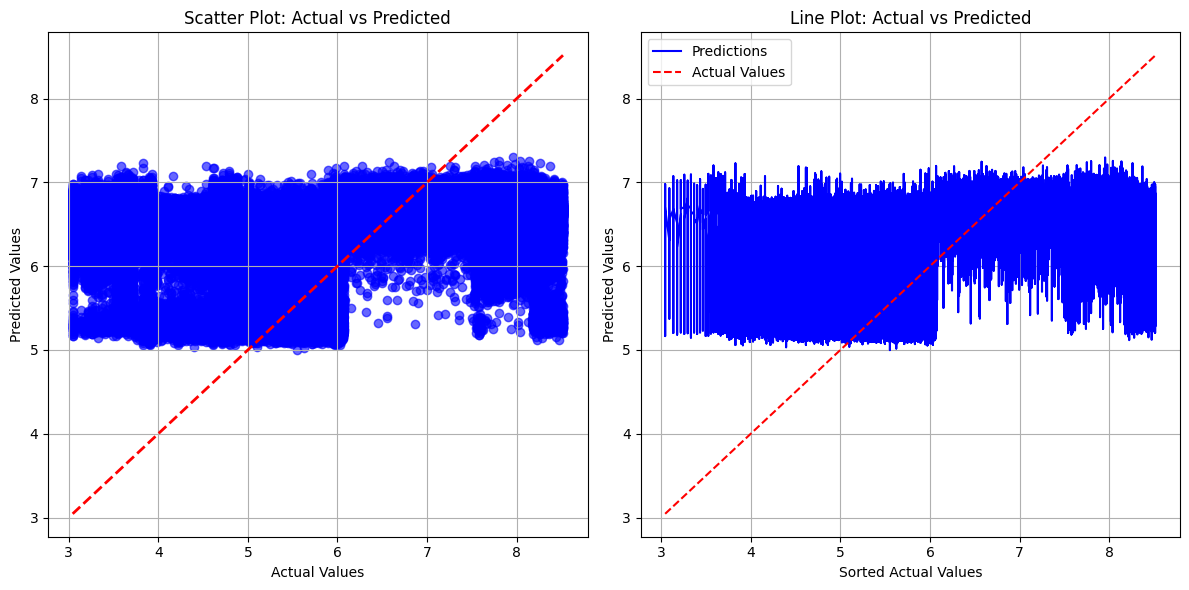

In [14]:
y_true = y
y_pred = oof_predictions

# Visualize the predictions
visualize_predictions(y_true, y_pred)
